In [1]:
import sys
import os
import json
import joblib
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import deque
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GroupShuffleSplit

# ==========================================
# 1. PATH SETUP
# ==========================================
# Assumes the notebook is located in a 'notebooks' subfolder.
# We resolve '..' to get the Project Root.
# If running from the root, change to Path('.')
PROJECT_ROOT = Path('..').resolve()

# Add project root to system path to allow imports from 'src'
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# ==========================================
# 2. LOCAL IMPORTS
# ==========================================
try:
    from src.utils_physics import preprocess_trajectory, compute_physics_features
    from src.utils_ml import compute_features, prepare_inference_window, apply_nms
    print("Imports from src/ successful!")
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Ensure that 'src' exists at: {PROJECT_ROOT}")

# ==========================================
# 3. DATA CONFIGURATION
# ==========================================
DATA_DIR = PROJECT_ROOT / "input_data/per_point_v2"
VIDEO_SOURCE = PROJECT_ROOT / "input_data/Alcaraz_Sinner_2025.mp4"
MODEL_PATH = PROJECT_ROOT / "tennis_xgb_supervised.pkl"

# Status Check
print(f"Data Directory found: {DATA_DIR.exists()}")
print(f"Video Source found:   {VIDEO_SOURCE.exists()}")
print(f"Model File found:     {MODEL_PATH.exists()}")

# ==========================================
# 4. VISUALIZATION SETTINGS
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
FPS = 50

Imports from src/ successful!
Data Directory found: True
Video Source found:   True
Model File found:     True


In [2]:
all_points = []
files = sorted(list(DATA_DIR.glob("ball_data_*.json")))

print(f"Loading {len(files)} points...")

for file in tqdm(files):
    with open(file) as f:
        point_data = json.load(f)
        point_id = int(file.stem.split("_")[-1])
        
        # Basic Stats Extraction
        frames = [int(k) for k in point_data.keys()]
        # Using .get() for safety in case 'action' or 'visible' keys are missing
        actions = [v.get("action", "air") for v in point_data.values()]
        visible = [v.get("visible", False) for v in point_data.values()]
        
        # Count explicit 'air' labels, or calculate later if they are None/Missing
        n_hit = actions.count("hit")
        n_bounce = actions.count("bounce")
        # Assuming anything not hit/bounce is air (if labeled 'air' or None)
        n_air = len(frames) - n_hit - n_bounce 
        
        all_points.append({
            "point_id": point_id,
            "n_frames": len(frames),
            "n_visible": sum(visible),
            "n_hit": n_hit,
            "n_bounce": n_bounce,
            "n_air": n_air
        })

df_stats = pd.DataFrame(all_points)

print("\n=== GLOBAL STATISTICS ===")
print(f"Total Points     : {len(df_stats)}")
print(f"Avg Duration     : {df_stats['n_frames'].mean():.1f} ± {df_stats['n_frames'].std():.1f} frames")
print(f"Visibility       : {(df_stats['n_visible'].sum() / df_stats['n_frames'].sum())*100:.1f}%")

print("\n=== CLASS DISTRIBUTION ===")
total_frames = df_stats['n_frames'].sum()
print(f"Air    : {df_stats['n_air'].sum()} ({df_stats['n_air'].sum()/total_frames*100:.2f}%)")
print(f"Hit    : {df_stats['n_hit'].sum()} ({df_stats['n_hit'].sum()/total_frames*100:.2f}%)")
print(f"Bounce : {df_stats['n_bounce'].sum()} ({df_stats['n_bounce'].sum()/total_frames*100:.2f}%)")

Loading 313 points...


  0%|          | 0/313 [00:00<?, ?it/s]


=== GLOBAL STATISTICS ===
Total Points     : 313
Avg Duration     : 566.6 ± 336.3 frames
Visibility       : 64.1%

=== CLASS DISTRIBUTION ===
Air    : 174295 (98.28%)
Hit    : 1600 (0.90%)
Bounce : 1446 (0.82%)


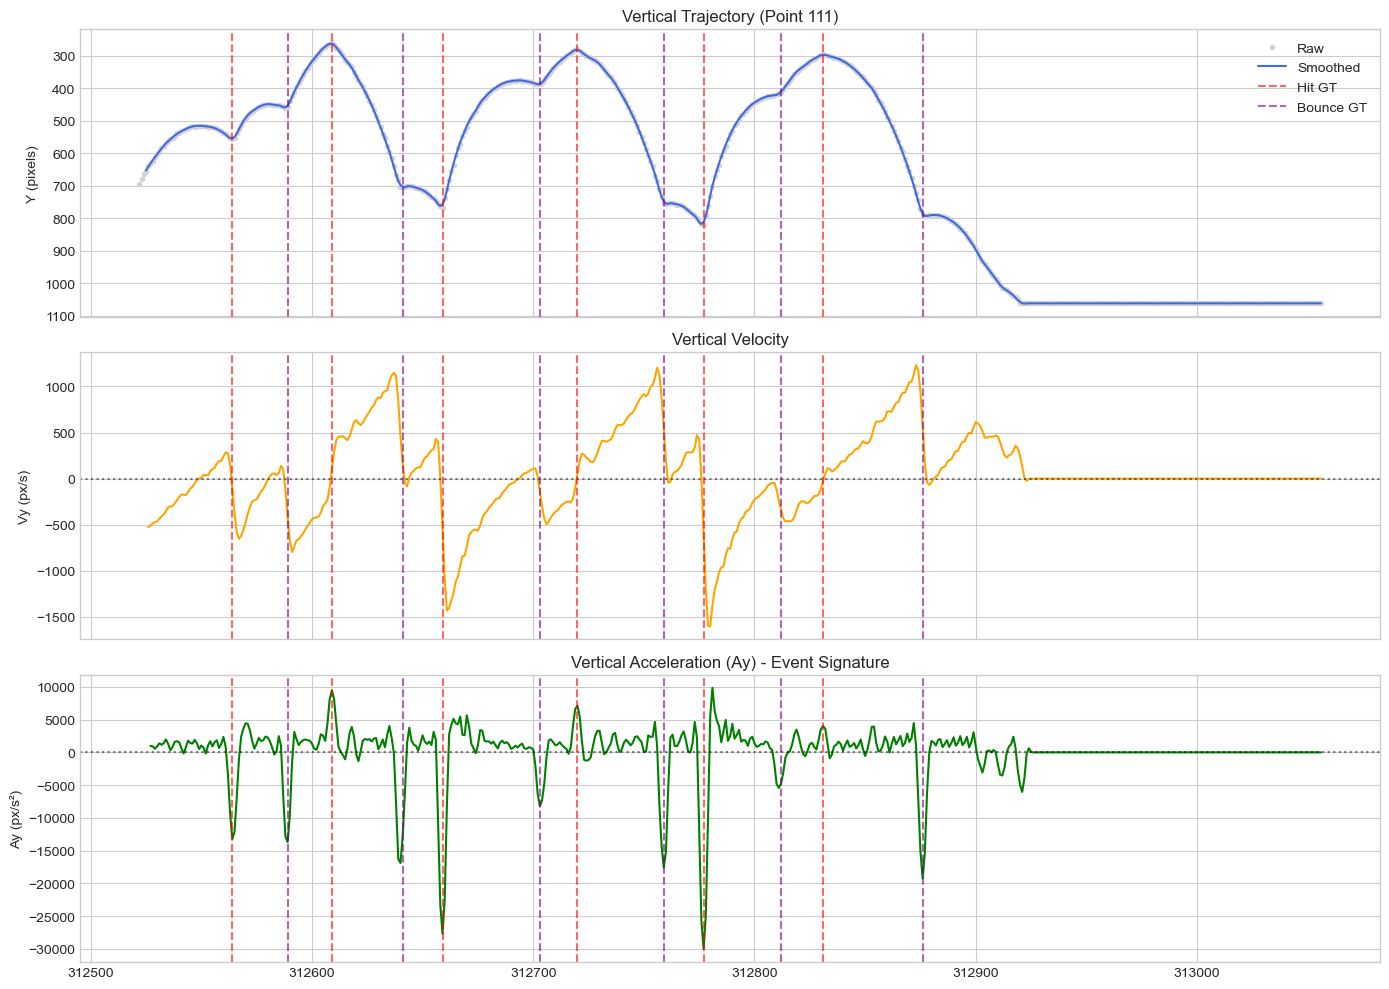

In [3]:
# Select point to visualize
POINT_ID = 111  # Change ID here (e.g., 111, 308, 102)
json_path = DATA_DIR / f"ball_data_{POINT_ID}.json"

if json_path.exists():
    with open(json_path) as f:
        data = json.load(f)
    
    # Computation
    df = preprocess_trajectory(data)
    df = compute_physics_features(df, fps=FPS)
    
    # Ground Truth Extraction
    hits = df[df['action'] == 'hit'].index
    bounces = df[df['action'] == 'bounce'].index
    
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # 1. Y Position
    axes[0].plot(df.index, df['y'], '.', color='lightgray', label='Raw')
    axes[0].plot(df.index, df['y_smooth'], '-', color='royalblue', label='Smoothed')
    axes[0].set_ylabel("Y (pixels)")
    axes[0].set_title(f"Vertical Trajectory (Point {POINT_ID})")
    axes[0].invert_yaxis() # Tennis: 0 is top
    axes[0].legend(loc='upper right')
    
    # 2. Vertical Velocity
    axes[1].plot(df.index, df['vy'], '-', color='orange', label='Vy')
    axes[1].axhline(0, color='black', linestyle=':', alpha=0.5)
    axes[1].set_ylabel("Vy (px/s)")
    axes[1].set_title("Vertical Velocity")
    
    # 3. Vertical Acceleration (The Physics Signature)
    axes[2].plot(df.index, df['ay'], '-', color='green', label='Ay')
    axes[2].axhline(0, color='black', linestyle=':', alpha=0.5)
    axes[2].set_ylabel("Ay (px/s²)")
    axes[2].set_title("Vertical Acceleration (Ay) - Event Signature")
    
    # Mark events on all subplots
    for ax in axes:
        for hit in hits:
            ax.axvline(hit, color='red', linestyle='--', alpha=0.6, label='Hit GT' if hit==hits[0] and ax==axes[0] else "")
        for bounce in bounces:
            ax.axvline(bounce, color='purple', linestyle='--', alpha=0.6, label='Bounce GT' if bounce==bounces[0] and ax==axes[0] else "")
            
    # Unified legend on the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[0].legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()
else:
    print(f"File not found: {json_path}")

In [4]:
# --- DIAGNOSTIC TOOL ---
def analyze_missed_events(data_directory):
    data_path = Path(data_directory)
    files = sorted(list(data_path.glob("ball_data_*.json")))
    print(f"Audit Missed Events on {len(files)} files...")
    
    audit_data = []
    error_count = 0
    
    for file in tqdm(files):
        try:
            with open(file, 'r') as f:
                data = json.load(f)
            
            # 1. Skip empty files
            if not data: 
                continue

            # Use imported function from src
            df = preprocess_trajectory(data)
            
            # 2. Check data length
            if len(df) < 5:
                continue
                
            # Use imported function from src
            df = compute_physics_features(df, fps=50)
            
            # Naive detection simulation (Ay peaks)
            # Ensure 'ay' exists (fill NaN just in case)
            if 'ay' not in df.columns: continue
            
            df['ay'] = df['ay'].fillna(0)
            df['ay_abs'] = df['ay'].abs()
            peaks, _ = find_peaks(df['ay_abs'], height=2000, prominence=1000, distance=10)
            
            # Ground Truth Comparison
            if 'action' in df.columns:
                gt_indices = df[df['action'].isin(['hit', 'bounce'])].index
                
                for gt in gt_indices:
                    label = df.loc[gt, 'action']
                    
                    # Is there a peak detected nearby?
                    matches = [p for p in peaks if abs(df.index[p] - gt) <= 5]
                    status = "Detected" if matches else "Missed_NoPeak"
                    
                    # Physics Feature
                    ay = abs(df.loc[gt, 'ay'])
                    
                    # --- GEOMETRY SAFETY CHECK ---
                    # Use index position (iloc) rather than label (loc) to avoid KeyErrors
                    if gt in df.index:
                        idx_pos = df.index.get_loc(gt)
                        
                        # Handle edges (start/end of video)
                        start = max(0, idx_pos - 5)
                        end = min(len(df), idx_pos + 6)
                        
                        local_y = df['y'].iloc[start:end]
                        
                        if not local_y.empty:
                            # Inverted Y: higher value = lower on screen
                            is_low_point = df.iloc[idx_pos]['y'] >= (local_y.max() - 5)
                        else:
                            is_low_point = False
                        
                        # Convexity (Negative acceleration peak = upward shock)
                        convexity = (df.loc[gt, 'ay'] < 0)
                        
                        audit_data.append({
                            'type': label,
                            'status': status,
                            'ay': ay,
                            'is_low_point': is_low_point,
                            'is_convex_peak': convexity
                        })
                
        except Exception as e:
            # Print only the FIRST error to debug, then continue silently
            if error_count == 0:
                print(f"Error on {file.name} : {e}")
            error_count += 1
            continue
    
    if error_count > 0:
        print(f"{error_count} files ignored due to errors.")

    # Return empty DataFrame if no data found to avoid crashes
    if not audit_data:
        return pd.DataFrame(columns=['type', 'status', 'ay', 'is_low_point', 'is_convex_peak'])
            
    return pd.DataFrame(audit_data)

# --- EXECUTION ---
# Assumes DATA_DIR is defined in previous cells
df_audit = analyze_missed_events(DATA_DIR)

# --- VISUALIZATION ---
if df_audit.empty:
    print("No data extracted. Check the error displayed above.")
else:
    print(f"Analysis successful on {len(df_audit)} events.")
    plt.figure(figsize=(15, 6))

    # 1. Low Point
    plt.subplot(1, 2, 1)
    sns.barplot(x='status', y='is_low_point', hue='type', data=df_audit)
    plt.title("Proportion of 'Low Point' (Geometric)")
    plt.ylabel("% Validated")

    # 2. Convexity
    plt.subplot(1, 2, 2)
    sns.barplot(x='status', y='is_convex_peak', hue='type', data=df_audit)
    plt.title("Proportion of 'Convex Peak' (Physics)")
    plt.ylabel("% Validated")

    plt.tight_layout()
    plt.show()

Audit Missed Events on 313 files...


  0%|          | 0/313 [00:00<?, ?it/s]

Error on ball_data_1.json : name 'find_peaks' is not defined
313 files ignored due to errors.
No data extracted. Check the error displayed above.


In [5]:
# ==========================================
# 1. PREDICTION PIPELINE
# ==========================================

def predict_point_logic(point_data, model, window_size=5):
    """
    Full Pipeline: JSON -> Preprocess -> Features -> Windowing -> Predict -> NMS.
    """
    # 1. Preprocessing (JSON to DataFrame, Interpolation)
    df = preprocess_trajectory(point_data)
    
    # 2. Feature Engineering (Physics)
    df = compute_features(df, fps=50)
    
    # 3. Prepare Input Matrix (Windowing)
    X = prepare_inference_window(df, window_size=window_size)
    
    # 4. Model Prediction
    probs = model.predict_proba(X)
    
    # 5. Post-Processing (Non-Maximum Suppression)
    preds = apply_nms(probs, threshold_hit=0.60, threshold_bounce=0.60, refractory=10)
    
    # 6. Format Output
    pred_dict = {}
    frame_ids = df.index.values
    for i, p in enumerate(preds):
        if p == 1: pred_dict[frame_ids[i]] = 'bounce'
        if p == 2: pred_dict[frame_ids[i]] = 'hit'
            
    return pred_dict

# ==========================================
# 2. VIDEO PROCESSING FUNCTIONS
# ==========================================

def extract_subvideo(video_path, start_frame, end_frame, temp_output="temp_clip.mp4"):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    out = cv2.VideoWriter(str(temp_output), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Extract frames
    count = 0
    total_frames = end_frame - start_frame + 1
    while count < total_frames:
        ret, frame = cap.read()
        if not ret: break
        out.write(frame)
        count += 1
        
    cap.release()
    out.release()
    return temp_output

def create_comparison_video(clip_path, point_data, pred_dict, output_video_path):
    cap = cv2.VideoCapture(str(clip_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    out = cv2.VideoWriter(str(output_video_path), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Prepare Visualization Data
    df = pd.DataFrame.from_dict(point_data, orient='index')
    df.index = df.index.astype(int)
    # Visual interpolation for smoothness
    df[['x', 'y']] = df[['x', 'y']].astype(float).interpolate(limit_direction='both')
    
    start_frame_global = df.index.min()
    current_frame_idx = 0
    ball_tail = deque(maxlen=int(1.0 * fps))
    events_display_buffer = [] 
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        global_frame = start_frame_global + current_frame_idx
        
        # Draw Ball and Tail
        if global_frame in df.index:
            row = df.loc[global_frame]
            x, y = int(row['x']), int(row['y'])
            ball_tail.append((x, y))
            
            for i in range(1, len(ball_tail)):
                cv2.line(frame, ball_tail[i-1], ball_tail[i], (0, 255, 255), 2)
            cv2.circle(frame, (x, y), 5, (0, 255, 255), -1)

            # Check Events (Ground Truth vs Prediction)
            gt_action = point_data.get(str(global_frame), {}).get('action', 'air')
            pred_action = pred_dict.get(global_frame, 'air')
            
            if gt_action != 'air':
                events_display_buffer.append({'type': 'GT', 'action': gt_action, 'pos': (x, y), 'life': 20})
            if pred_action != 'air':
                # Offset prediction slightly to be visible
                events_display_buffer.append({'type': 'IA', 'action': pred_action, 'pos': (x+15, y-15), 'life': 20})
        
        # Draw Persistent Events
        new_buffer = []
        for event in events_display_buffer:
            x, y = event['pos']
            color = (255, 0, 0) if event['type'] == 'GT' else (0, 0, 255)
            label = event['type']
            
            if event['action'] == 'bounce':
                cv2.circle(frame, (x, y), 20, color, 2)
                cv2.putText(frame, f"{label}:Bounce", (x-30, y-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            elif event['action'] == 'hit':
                cv2.line(frame, (x-15, y-15), (x+15, y+15), color, 3)
                cv2.line(frame, (x-15, y+15), (x+15, y-15), color, 3)
                cv2.putText(frame, f"{label}:Hit", (x-30, y-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            event['life'] -= 1
            if event['life'] > 0: new_buffer.append(event)
        events_display_buffer = new_buffer
        
        # Legend
        cv2.putText(frame, "Blue: Ground Truth", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, "Red: AI Model", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        out.write(frame)
        current_frame_idx += 1
        
    cap.release()
    out.release()
    print(f"Comparison video generated: {output_video_path}")

# ==========================================
# 3. EXECUTION
# ==========================================

POINT_ID_TO_TEST = 102

if not MODEL_PATH.exists():
    print(f"Error: Model not found at {MODEL_PATH}")
else:
    print(f"Loading model: {MODEL_PATH.name}")
    model = joblib.load(MODEL_PATH)
    
    # Load point data
    json_path = DATA_DIR / f"ball_data_{POINT_ID_TO_TEST}.json"
    
    if not json_path.exists():
        print(f"Error: JSON not found: {json_path}")
    else:
        print(f"Processing point {POINT_ID_TO_TEST}...")
        with open(json_path, 'r') as f:
            point_data = json.load(f)
        
        # Predict
        pred_dict = predict_point_logic(point_data, model)
        
        n_bounce = list(pred_dict.values()).count('bounce')
        n_hit = list(pred_dict.values()).count('hit')
        print(f"Stats: {n_bounce} bounces, {n_hit} hits detected.")
        
        # Video Pipeline
        df = pd.DataFrame.from_dict(point_data, orient='index')
        df.index = df.index.astype(int)
        start_f, end_f = df.index.min(), df.index.max()
        
        temp_clip = PROJECT_ROOT / "temp_raw_clip.mp4"
        print("Extracting source video clip...")
        extract_subvideo(VIDEO_SOURCE, start_f, end_f, temp_output=temp_clip)
        
        output_name = PROJECT_ROOT / f"result_point_{POINT_ID_TO_TEST}_comparison.mp4"
        print("Generating overlay...")
        create_comparison_video(temp_clip, point_data, pred_dict, output_name)
        
        # Cleanup
        if temp_clip.exists():
            os.remove(temp_clip)

Loading model: tennis_xgb_supervised.pkl
Processing point 102...
Stats: 7 bounces, 7 hits detected.
Extracting source video clip...
Generating overlay...
Comparison video generated: /Users/hugo.niedzielski/Documents/PFE/quantum_analytics/tennis_hit_bounce/result_point_102_comparison.mp4


Imports from src/ successful!
Processing 313 sequences with Physics Heuristics...


  0%|          | 0/313 [00:00<?, ?it/s]


=== FRAME-PERFECT METRICS (PHYSICS) ===
              precision    recall  f1-score   support

         air      0.993     0.990     0.992    216872
      bounce      0.381     0.542     0.448      1446
         hit      0.444     0.497     0.469      1600

    accuracy                          0.983    219918
   macro avg      0.606     0.676     0.636    219918
weighted avg      0.985     0.983     0.984    219918


RESULTS WITH TOLERANCE (+/- 2 frames)
-----------------------------------------------------------------
Class      | Precision  | Recall     | F1-Score  
-----------------------------------------------------------------
Bounce     | 0.616      | 0.877      | 0.724
Hit        | 0.673      | 0.753      | 0.711
-----------------------------------------------------------------


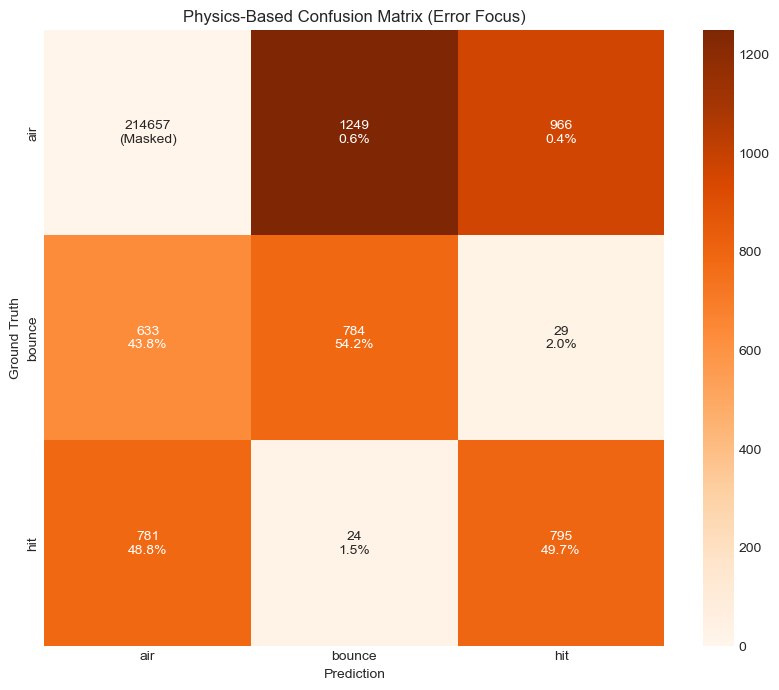

In [11]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Import local modules from src
try:
    from src.utils_physics import preprocess_trajectory, compute_physics_features
    print("Imports from src/ successful!")
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Ensure that 'src' exists at: {PROJECT_ROOT}")

# Configuration
DATA_DIR = PROJECT_ROOT / "input_data/per_point_v2"
FPS = 50

# Map for consistency with XGBoost (Air=0, Bounce=1, Hit=2)
LABEL_MAP = {'air': 0, 'bounce': 1, 'hit': 2}
REV_LABEL_MAP = {0: 'air', 1: 'bounce', 2: 'hit'}

# ==========================================
# 2. EVALUATION METRICS TOOLS
# ==========================================

def evaluate_with_tolerance(y_true, y_pred, tolerance=2):
    """
    Calculates Precision/Recall/F1 allowing for a temporal shift (tolerance).
    Expects integer inputs (0, 1, 2).
    """
    labels = [1, 2] # 1: Bounce, 2: Hit
    names = {1: "Bounce", 2: "Hit"}
    
    print(f"\nRESULTS WITH TOLERANCE (+/- {tolerance} frames)")
    print("-" * 65)
    print(f"{'Class':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 65)
    
    for label in labels:
        true_indices = np.where(y_true == label)[0]
        pred_indices = np.where(y_pred == label)[0]
        
        # Recall: Did we find the event?
        tp_recall = 0
        for t_idx in true_indices:
            if np.any(np.abs(pred_indices - t_idx) <= tolerance):
                tp_recall += 1
        recall = tp_recall / len(true_indices) if len(true_indices) > 0 else 0
        
        # Precision: Is the predicted event real?
        tp_precision = 0
        for p_idx in pred_indices:
            if np.any(np.abs(true_indices - p_idx) <= tolerance):
                tp_precision += 1
        precision = tp_precision / len(pred_indices) if len(pred_indices) > 0 else 0
        
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"{names[label]:<10} | {precision:.3f}      | {recall:.3f}      | {f1:.3f}")
    print("-" * 65)

def plot_focused_confusion_matrix(y_true, y_pred, classes=['air', 'bounce', 'hit']):
    """ Displays the Confusion Matrix masking the dominant Air-Air cell. """
    cm = confusion_matrix(y_true, y_pred)
    cm_focused = cm.copy()
    cm_focused[0, 0] = 0 # Mask 'Air-Air' for better visibility of errors
    
    plt.figure(figsize=(10, 8))
    annot = np.empty_like(cm).astype(object)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm[i, j] / cm[i].sum() if cm[i].sum() > 0 else 0
            if i == 0 and j == 0: annot[i, j] = f"{c}\n(Masked)"
            else: annot[i, j] = f"{c}\n{p:.1%}"
    
    sns.heatmap(cm_focused, annot=annot, fmt='', cmap='Oranges', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Physics-Based Confusion Matrix (Error Focus)')
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.show()

# ==========================================
# 3. HEURISTIC DETECTION LOGIC
# ==========================================

def run_physics_heuristics(df):
    """
    Applies physical rules to detect events.
    Returns a dict {frame_id: 'bounce'/'hit'}.
    """
    # Heuristic Parameters
    PEAK_HEIGHT = 2500      
    CONVEX_THRESH = -1200   
    ENERGY_THRESH = 200     
    VIOLENCE_THRESH = 25000 
    REFRACTORY_PERIOD = 10  
    
    # 1. Peak Detection
    df['ay'] = df['ay'].fillna(0)
    df['ay_abs'] = df['ay'].abs()
    
    peaks, _ = find_peaks(df['ay_abs'], height=PEAK_HEIGHT, prominence=1000, distance=5)
    
    candidates = []
    
    # 2. Rule Application
    for i in peaks:
        frame_id = df.index[i]
        
        offset = 5
        if i - offset < 0 or i + offset >= len(df): 
            continue
            
        vx_pre = df['vx'].iloc[i - offset]
        vx_post = df['vx'].iloc[i + offset]
        
        vx_prod = vx_pre * vx_post
        delta_vx_mag = abs(vx_post) - abs(vx_pre)
        max_vx = max(abs(vx_pre), abs(vx_post))
        
        ay_val_raw = df['ay'].iloc[i]
        ay_val_abs = abs(ay_val_raw)
        
        is_convex_bounce = (ay_val_raw < CONVEX_THRESH)
        is_moving = (max_vx > 150)
        
        pred = 'air'
        priority = 0
        
        if ((vx_prod < 0) and is_moving) or \
           (delta_vx_mag > ENERGY_THRESH) or \
           (ay_val_abs > VIOLENCE_THRESH):
            pred = 'hit'
            priority = 2
        elif (vx_prod > 0) and is_convex_bounce:
            pred = 'bounce'
            priority = 1
            
        if pred != 'air':
            candidates.append((frame_id, pred, ay_val_abs, priority))
            
    # 3. Temporal Cleaning
    final_events = {}
    candidates.sort(key=lambda x: x[0])
    
    if candidates:
        curr = candidates[0]
        for next_evt in candidates[1:]:
            if next_evt[0] - curr[0] < REFRACTORY_PERIOD:
                if next_evt[3] > curr[3]: 
                    curr = next_evt
                elif next_evt[3] == curr[3] and next_evt[2] > curr[2]:
                    curr = next_evt
            else:
                final_events[curr[0]] = curr[1]
                curr = next_evt
        final_events[curr[0]] = curr[1]
        
    return final_events

# ==========================================
# 4. EXECUTION PIPELINE
# ==========================================

if not DATA_DIR.exists():
    print(f"Error: Data folder not found at {DATA_DIR}")
else:
    json_files = sorted(list(DATA_DIR.glob("*.json")))
    print(f"Processing {len(json_files)} sequences with Physics Heuristics...")
    
    y_true_all = []
    y_pred_all = []
    
    for file_path in tqdm(json_files):
        try:
            with open(file_path, 'r') as f:
                point_data = json.load(f)
            
            # A. Prepare Data (Using src functions)
            df = preprocess_trajectory(point_data)
            
            if len(df) < 5: 
                continue
                
            df = compute_physics_features(df, fps=FPS)
            
            # B. Ground Truth (Convert to Int)
            if 'action' not in df.columns:
                df['action'] = 'air'
            df['label'] = df['action'].fillna('air').map(LABEL_MAP)
            
            # C. Run Detection
            detected_events_dict = run_physics_heuristics(df)
            
            # D. Align GT and Preds (Frame by Frame)
            for frame_id in df.index:
                gt_val = int(df.loc[frame_id, 'label'])
                
                # Get prediction string and convert to int
                pred_str = detected_events_dict.get(frame_id, 'air')
                pred_val = LABEL_MAP.get(pred_str, 0)
                
                y_true_all.append(gt_val)
                y_pred_all.append(pred_val)
                
        except Exception as e:
            # print(f"Skipping {file_path.name}: {e}")
            continue
            
    # ==========================================
    # 5. REPORTING
    # ==========================================
    
    if len(y_true_all) > 0:
        # Convert lists to numpy arrays for the functions
        y_true_np = np.array(y_true_all)
        y_pred_np = np.array(y_pred_all)
        
        target_names = ['air', 'bounce', 'hit']
        
        print("\n=== FRAME-PERFECT METRICS (PHYSICS) ===")
        print(classification_report(y_true_np, y_pred_np, target_names=target_names, digits=3))
        
        # Evaluate with tolerance
        evaluate_with_tolerance(y_true_np, y_pred_np, tolerance=2)
        
        # Plot Matrix
        plot_focused_confusion_matrix(y_true_np, y_pred_np, classes=target_names)
        
    else:
        print("Error: No valid data processed.")

Loading and processing 313 files from per_point_v2...


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluating on Test Set (34300 frames)...
Model loaded: tennis_xgb_supervised.pkl

=== FRAME-PERFECT METRICS ===
              precision    recall  f1-score   support

         air      0.996     0.996     0.996     33721
      bounce      0.754     0.779     0.767       272
         hit      0.781     0.756     0.768       307

    accuracy                          0.992     34300
   macro avg      0.844     0.844     0.844     34300
weighted avg      0.992     0.992     0.992     34300


RESULTS WITH TOLERANCE (+/- 2 frames)
-----------------------------------------------------------------
Class      | Precision  | Recall     | F1-Score  
-----------------------------------------------------------------
Bounce     | 0.851      | 0.882      | 0.866
Hit        | 0.875      | 0.847      | 0.861
-----------------------------------------------------------------


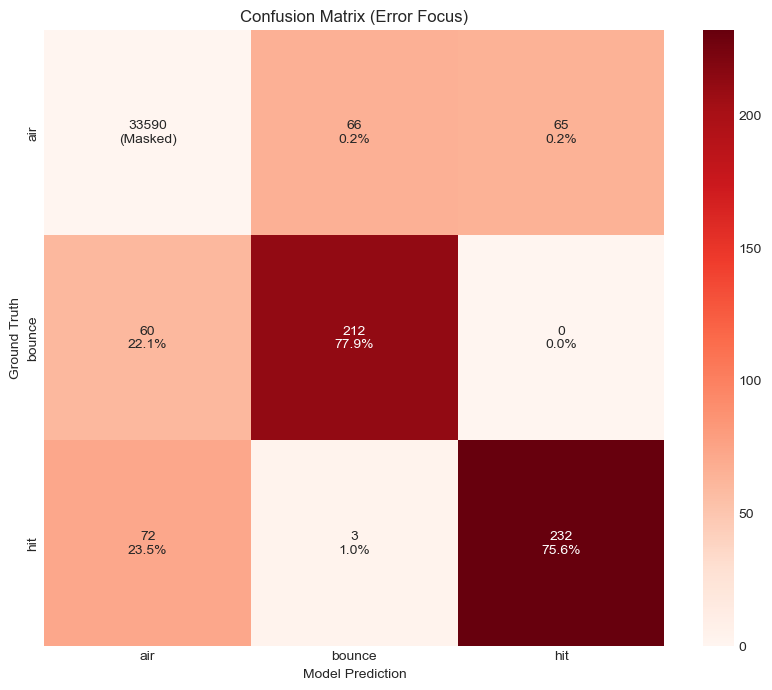

In [7]:

WINDOW_SIZE = 5

# ==========================================
# 2. EVALUATION METRICS TOOLS
# ==========================================

def evaluate_with_tolerance(y_true, y_pred, tolerance=2):
    """
    Calculates Precision/Recall/F1 allowing for a temporal shift (tolerance).
    """
    labels = [1, 2] # 1: Bounce, 2: Hit
    names = {1: "Bounce", 2: "Hit"}
    
    print(f"\nRESULTS WITH TOLERANCE (+/- {tolerance} frames)")
    print("-" * 65)
    print(f"{'Class':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 65)
    
    for label in labels:
        true_indices = np.where(y_true == label)[0]
        pred_indices = np.where(y_pred == label)[0]
        
        # Recall: Did we find the event?
        tp_recall = 0
        for t_idx in true_indices:
            if np.any(np.abs(pred_indices - t_idx) <= tolerance):
                tp_recall += 1
        recall = tp_recall / len(true_indices) if len(true_indices) > 0 else 0
        
        # Precision: Is the predicted event real?
        tp_precision = 0
        for p_idx in pred_indices:
            if np.any(np.abs(true_indices - p_idx) <= tolerance):
                tp_precision += 1
        precision = tp_precision / len(pred_indices) if len(pred_indices) > 0 else 0
        
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"{names[label]:<10} | {precision:.3f}      | {recall:.3f}      | {f1:.3f}")
    print("-" * 65)

def plot_focused_confusion_matrix(y_true, y_pred, classes=['air', 'bounce', 'hit']):
    """ Displays the Confusion Matrix masking the dominant Air-Air cell. """
    cm = confusion_matrix(y_true, y_pred)
    cm_focused = cm.copy()
    cm_focused[0, 0] = 0 # Mask 'Air-Air' for better visibility of errors
    
    plt.figure(figsize=(10, 8))
    annot = np.empty_like(cm).astype(object)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm[i, j] / cm[i].sum() if cm[i].sum() > 0 else 0
            if i == 0 and j == 0: annot[i, j] = f"{c}\n(Masked)"
            else: annot[i, j] = f"{c}\n{p:.1%}"
    
    sns.heatmap(cm_focused, annot=annot, fmt='', cmap='Reds', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (Error Focus)')
    plt.ylabel('Ground Truth')
    plt.xlabel('Model Prediction')
    plt.show()

# ==========================================
# 3. DATA LOADING (Iterative Folder Logic)
# ==========================================

def load_and_prepare_data_from_folder(data_dir, window_size=5):
    """
    Iterates over all JSON files in the folder, computes features,
    and aggregates them into X, y arrays.
    """
    json_files = sorted(list(data_dir.glob("*.json")))
    
    if not json_files:
        raise FileNotFoundError(f"No JSON files found in {data_dir}")
        
    print(f"Loading and processing {len(json_files)} files from {data_dir.name}...")
    
    X, y, groups = [], [], []
    label_map = {'air': 0, 'bounce': 1, 'hit': 2}
    
    for file_path in tqdm(json_files):
        try:
            with open(file_path, 'r') as f:
                point_data = json.load(f)
            
            # Convert to DataFrame
            df = pd.DataFrame.from_dict(point_data, orient='index')
            df.index = df.index.astype(int)
            df = df.sort_index()
            
            # Ground Truth setup
            if 'action' not in df.columns: 
                df['action'] = 'air'
            df['label'] = df['action'].fillna('air').map(label_map)
            
            # Feature Engineering (src utils)
            df = compute_features(df, fps=FPS)
            
            # Windowing (src utils)
            X_seq = prepare_inference_window(df, window_size=window_size)
            y_seq = df['label'].values
            
            # Validation
            if len(X_seq) == len(y_seq) and len(X_seq) > 0:
                X.append(X_seq)
                y.append(y_seq)
                # Use filename stem as group ID (e.g. "ball_data_12")
                groups.append([file_path.stem] * len(y_seq))
                
        except Exception as e:
            print(f"Skipping {file_path.name}: {e}")
            continue
            
    if not X:
        return np.array([]), np.array([]), np.array([])
        
    return np.vstack(X), np.concatenate(y), np.concatenate(groups)

# ==========================================
# 4. EXECUTION PIPELINE
# ==========================================

if not DATA_DIR.exists() or not MODEL_PATH.exists():
    print(f"Error: Check paths.\nData: {DATA_DIR}\nModel: {MODEL_PATH}")
else:
    # 1. Load Data
    X, y, groups = load_and_prepare_data_from_folder(DATA_DIR, WINDOW_SIZE)
    
    if len(X) > 0:
        # 2. Re-create the Test Split (20%)
        # It is crucial to use the same random_state=42 as in training
        # to ensure we test on data the model hasn't seen.
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, test_idx = next(gss.split(X, y, groups))
        
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        print(f"Evaluating on Test Set ({len(y_test)} frames)...")
        
        # 3. Load Model
        model = joblib.load(MODEL_PATH)
        print(f"Model loaded: {MODEL_PATH.name}")
        
        # 4. Predict
        probs = model.predict_proba(X_test)
        
        # 5. Apply NMS (Post-processing)
        preds = apply_nms(probs, threshold_hit=0.60, threshold_bounce=0.60, refractory=10)
        
        # 6. Report Metrics
        print("\n=== FRAME-PERFECT METRICS ===")
        print(classification_report(y_test, preds, target_names=['air', 'bounce', 'hit'], digits=3))
        
        evaluate_with_tolerance(y_test, preds, tolerance=2)
        
        # 7. Confusion Matrix
        plot_focused_confusion_matrix(y_test, preds)
    else:
        print("Error: No valid data loaded.")